In [48]:
#引入相关包
import torch
import torchvision
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm


In [49]:
#相关参数
n_epochs = 30   #训练的轮次
batch_size = 64   #batch_size
learning_rate = 0.01   #学习率
momentum = 0.5     #momentum梯度下降时的超参数
log_interval = 10  #画图的记录点

In [50]:
#设置训练集和测试集
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/', train=True, download=True,
                            transform=torchvision.transforms.ToTensor(),),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/', train=False, download=True,
                            transform=torchvision.transforms.ToTensor(),),
    batch_size=batch_size, shuffle=True)


In [51]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)  
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) 
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50) 
        self.fc2 = nn.Linear(50, 10)  

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) 
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))  
        x = x.view(x.size(0), -1)  
        x = F.relu(self.fc1(x)) 
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.softmax(x, dim=1) 

# network = Net()

In [52]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)  
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) 
        self.fc1 = nn.Linear(320, 50) 
        self.fc2 = nn.Linear(50, 10)  

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) 
        x = F.relu(F.max_pool2d(self.conv2(x), 2))  
        x = x.view(x.size(0), -1)  
        x = F.relu(self.fc1(x)) 
        x = self.fc2(x)
        return F.softmax(x, dim=1) 

network = Net2()

In [53]:
#梯度优化方式采用SGD，带有momentum
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

#用于之后画图时候展示损失函数的下降过程
train_losses = []
train_counter = []
test_losses = []
test_counter = [i * len(train_loader.dataset) for i in range(n_epochs + 1)]

loss_f = nn.CrossEntropyLoss()  #这里我们使用交叉熵损失函数


In [54]:
#训练模型的函数
def train(epoch):
    loop = tqdm(train_loader, leave=True)
    loss_all = 0
    network.train()  #表示进入了测试模式
    for batch_idx, (data, target) in enumerate(loop):
        optimizer.zero_grad()  #旧的梯度清零
        output = network(data)  #正向传播
        loss = loss_f(output, target)  #计算损失
        loss.backward()    #计算梯度
        optimizer.step()   #梯度下降
        loss_all += loss  #计算dataset的总loss
        loop.set_postfix(loss=loss.item())  #画图相关

        #每隔一段时间记录下当前的loss以便画图
        if batch_idx % log_interval == 0:
            train_losses.append(loss.item())
            train_counter.append((batch_idx * 64) + ((epoch - 1) * len(train_loader.dataset)))

#测试模型的函数
def test(epoch):
    network.eval()   #表明进入测试模式
    test_loss = 0      #测试的总损失
    correct = 0         #测试的总正确数量
    with torch.no_grad():  #在测试的时候需要取消模型的梯度
        for data, target in test_loader:
            output = network(data)
            test_loss += loss_f(output, target)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    
    test_loss /= (len(test_loader.dataset)/batch_size) 
    test_losses.append(test_loss.item())
    print('Epoch: {},Test set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(epoch,
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [55]:
test(0)
#开始训练
for epoch in range(1, n_epochs + 1):
    train(epoch) 
    test(epoch)

Epoch: 0,Test set: Avg. loss: 2.3137, Accuracy: 993/10000 (10%)



100%|██████████| 938/938 [00:14<00:00, 62.76it/s, loss=2.3] 


Epoch: 1,Test set: Avg. loss: 2.3122, Accuracy: 1766/10000 (18%)



100%|██████████| 938/938 [00:14<00:00, 62.94it/s, loss=2.3] 


Epoch: 2,Test set: Avg. loss: 2.3077, Accuracy: 2239/10000 (22%)



100%|██████████| 938/938 [00:15<00:00, 62.30it/s, loss=1.92]


Epoch: 3,Test set: Avg. loss: 1.9846, Accuracy: 5528/10000 (55%)



100%|██████████| 938/938 [00:14<00:00, 65.82it/s, loss=1.58]


Epoch: 4,Test set: Avg. loss: 1.6655, Accuracy: 8192/10000 (82%)



100%|██████████| 938/938 [00:14<00:00, 65.93it/s, loss=1.65]


Epoch: 5,Test set: Avg. loss: 1.6350, Accuracy: 8385/10000 (84%)



100%|██████████| 938/938 [00:14<00:00, 65.95it/s, loss=1.67]


Epoch: 6,Test set: Avg. loss: 1.6219, Accuracy: 8518/10000 (85%)



100%|██████████| 938/938 [00:14<00:00, 64.51it/s, loss=1.63]


Epoch: 7,Test set: Avg. loss: 1.6124, Accuracy: 8591/10000 (86%)



100%|██████████| 938/938 [00:15<00:00, 59.28it/s, loss=1.68]


Epoch: 8,Test set: Avg. loss: 1.6065, Accuracy: 8647/10000 (86%)



100%|██████████| 938/938 [00:14<00:00, 62.94it/s, loss=1.57]


Epoch: 9,Test set: Avg. loss: 1.6024, Accuracy: 8682/10000 (87%)



100%|██████████| 938/938 [00:14<00:00, 65.46it/s, loss=1.5] 


Epoch: 10,Test set: Avg. loss: 1.5968, Accuracy: 8737/10000 (87%)



100%|██████████| 938/938 [00:14<00:00, 65.85it/s, loss=1.57]


Epoch: 11,Test set: Avg. loss: 1.5997, Accuracy: 8707/10000 (87%)



100%|██████████| 938/938 [00:14<00:00, 65.93it/s, loss=1.55]


Epoch: 12,Test set: Avg. loss: 1.5920, Accuracy: 8775/10000 (88%)



100%|██████████| 938/938 [00:14<00:00, 66.00it/s, loss=1.61]


Epoch: 13,Test set: Avg. loss: 1.5912, Accuracy: 8782/10000 (88%)



100%|██████████| 938/938 [00:14<00:00, 66.04it/s, loss=1.6] 


Epoch: 14,Test set: Avg. loss: 1.5889, Accuracy: 8800/10000 (88%)



100%|██████████| 938/938 [00:14<00:00, 64.63it/s, loss=1.59]


Epoch: 15,Test set: Avg. loss: 1.5870, Accuracy: 8828/10000 (88%)



100%|██████████| 938/938 [00:14<00:00, 65.96it/s, loss=1.52]


Epoch: 16,Test set: Avg. loss: 1.5855, Accuracy: 8831/10000 (88%)



100%|██████████| 938/938 [00:14<00:00, 66.01it/s, loss=1.66]


Epoch: 17,Test set: Avg. loss: 1.5853, Accuracy: 8838/10000 (88%)



100%|██████████| 938/938 [00:14<00:00, 63.74it/s, loss=1.56]


Epoch: 18,Test set: Avg. loss: 1.5851, Accuracy: 8846/10000 (88%)



100%|██████████| 938/938 [00:14<00:00, 63.11it/s, loss=1.55]


Epoch: 19,Test set: Avg. loss: 1.5837, Accuracy: 8856/10000 (89%)



100%|██████████| 938/938 [00:14<00:00, 63.55it/s, loss=1.6] 


Epoch: 20,Test set: Avg. loss: 1.5826, Accuracy: 8862/10000 (89%)



100%|██████████| 938/938 [00:15<00:00, 62.37it/s, loss=1.53]


Epoch: 21,Test set: Avg. loss: 1.5850, Accuracy: 8836/10000 (88%)



100%|██████████| 938/938 [00:15<00:00, 60.94it/s, loss=1.51]


Epoch: 22,Test set: Avg. loss: 1.5820, Accuracy: 8869/10000 (89%)



100%|██████████| 938/938 [00:15<00:00, 62.14it/s, loss=1.56]


Epoch: 23,Test set: Avg. loss: 1.5841, Accuracy: 8839/10000 (88%)



100%|██████████| 938/938 [00:14<00:00, 63.80it/s, loss=1.61]


Epoch: 24,Test set: Avg. loss: 1.5803, Accuracy: 8880/10000 (89%)



100%|██████████| 938/938 [00:14<00:00, 64.12it/s, loss=1.52]


Epoch: 25,Test set: Avg. loss: 1.5804, Accuracy: 8879/10000 (89%)



100%|██████████| 938/938 [00:14<00:00, 65.14it/s, loss=1.56]


Epoch: 26,Test set: Avg. loss: 1.5808, Accuracy: 8877/10000 (89%)



100%|██████████| 938/938 [00:15<00:00, 61.53it/s, loss=1.66]


Epoch: 27,Test set: Avg. loss: 1.5799, Accuracy: 8883/10000 (89%)



100%|██████████| 938/938 [00:15<00:00, 62.44it/s, loss=1.52]


Epoch: 28,Test set: Avg. loss: 1.5795, Accuracy: 8887/10000 (89%)



100%|██████████| 938/938 [00:16<00:00, 57.21it/s, loss=1.6] 


Epoch: 29,Test set: Avg. loss: 1.5805, Accuracy: 8878/10000 (89%)



100%|██████████| 938/938 [00:15<00:00, 59.59it/s, loss=1.67]


Epoch: 30,Test set: Avg. loss: 1.5796, Accuracy: 8888/10000 (89%)



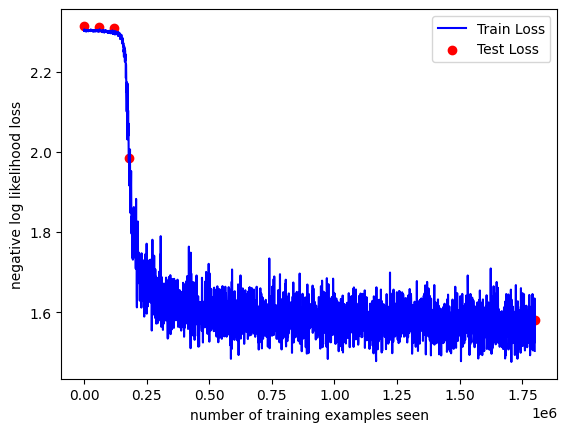

In [56]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()

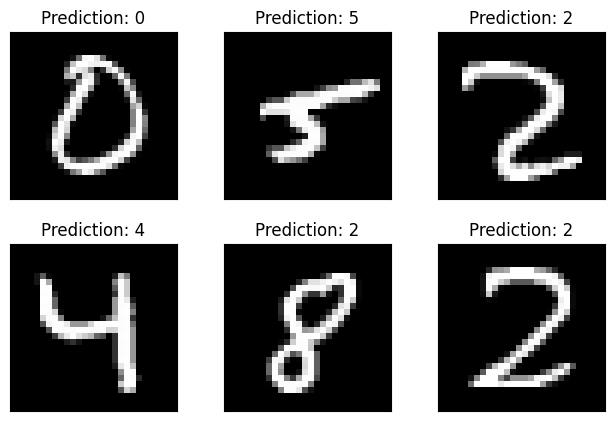

In [57]:
#这里是验证的相关代码  可以直观的展示我们的预测结果  可以看到相关的结果预测的还是非常的准确的
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
with torch.no_grad():
    output = network(example_data)
fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])
plt.show()